# Node.11 Project

In [52]:
# private score : 109,722 -> Xgboost로 GridSearch

In [74]:
#!pip install folium pgeocode

In [73]:
#!conda install -c conda-forge -y xgboost=3.0.2 lightgbm=4.6.0 missingno=0.5.2

## 데이터 및 라이브러리 불러오기

In [55]:
#!wget https://d3s0tskafalll9.cloudfront.net/media/documents/kaggle-kakr-housing-data.zip
#!unzip kaggle-kakr-housing-data.zip -d ~/work/kaggle_kakr_housing/

In [14]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import pgeocode

In [4]:
path = os.path.join(os.getenv('HOME'), 'work/project/Exploration/Quest02/kaggle_kakr_housing/data/')

#sample = pd.read_csv(path + "sample_submission.csv") # 대회에서 주는 submission은 말그대로 첫 제출용
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

# 무엇보다 train, test 합치진 않을 것 (개인 생각이니)

sub_id = test['id']

## 변수 설명
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [5]:
# 연속형 변수
continuous_vars = [
    'sqft_living',  # 주거 공간의 평방 피트
    'sqft_lot',     # 부지의 평방 피트
    'sqft_above',   # 지하실을 제외한 평방 피트
    'sqft_basement',# 지하실의 평방 피트
    'lat',          # 위도
    'long',         # 경도
    'sqft_living15',# 근처 15가구의 주거 공간, 평방 피트
    'sqft_lot15'    # 근처 15가구의 부지, 평방 피트
]

# 이산형 변수
discrete_vars = [
    'bathrooms',    # 침실당 화장실 개수
    'bedrooms',     # 침실의 수
    'waterfront',   # 강이 흐르는지 유무 (리버뷰)
    'view',         # 집이 좋아 보이는 정도
    'condition',    # 집의 전반적인 상태
    'grade',        # King County 등급
    'floors',         # 집의 층수
    'zipcode'       # 우편번호
]

time_vars = [
    'year',    # 집 구매 년도
    'month',   # 집 구매 월
    'day',     # 집 구매 일
    'yr_built',     # 집을 지은 년도
    'yr_renovated', # 집을 재건축한 년도
]

In [6]:
# train, test 둘다 결측치는 없음
# 따로 변수 설명시 나와있지도 않음
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [7]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## 간단 전처리

In [8]:
# 쓸모없는 id는 먼저 제거
# 두번 실행하지 말 것. 에러남
train.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)

In [9]:
# date 컬럼 -> 날짜/시간 객체로 변경
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train.drop(columns='date', inplace=True)
# train['hour'] = train['date'].dt.hour # 전부 0이라서 제외

test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test.drop(columns='date', inplace=True)

## EDA

<Axes: >

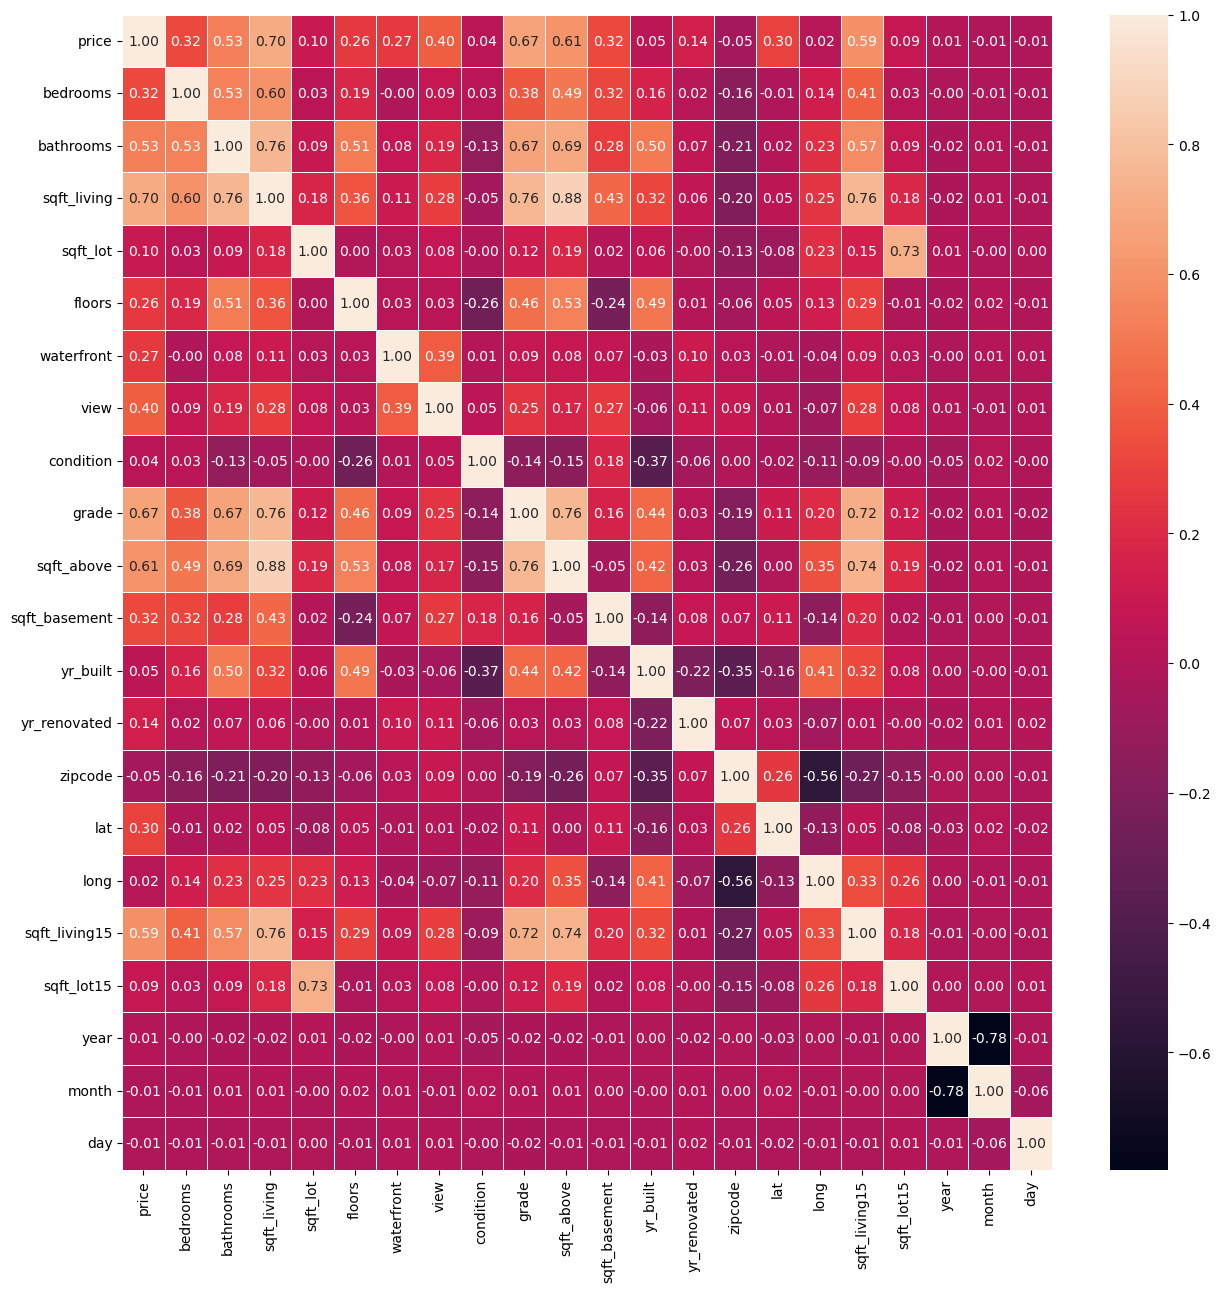

In [63]:
# 상관계수를 알아보자
plt.figure(figsize=(15,15)) 
sns.heatmap(data = train.corr(), annot=True, fmt = '.2f', linewidths=.5)

# 년,월,일은 생각보다 target과 관련이 거의 없어보이긴 한다.

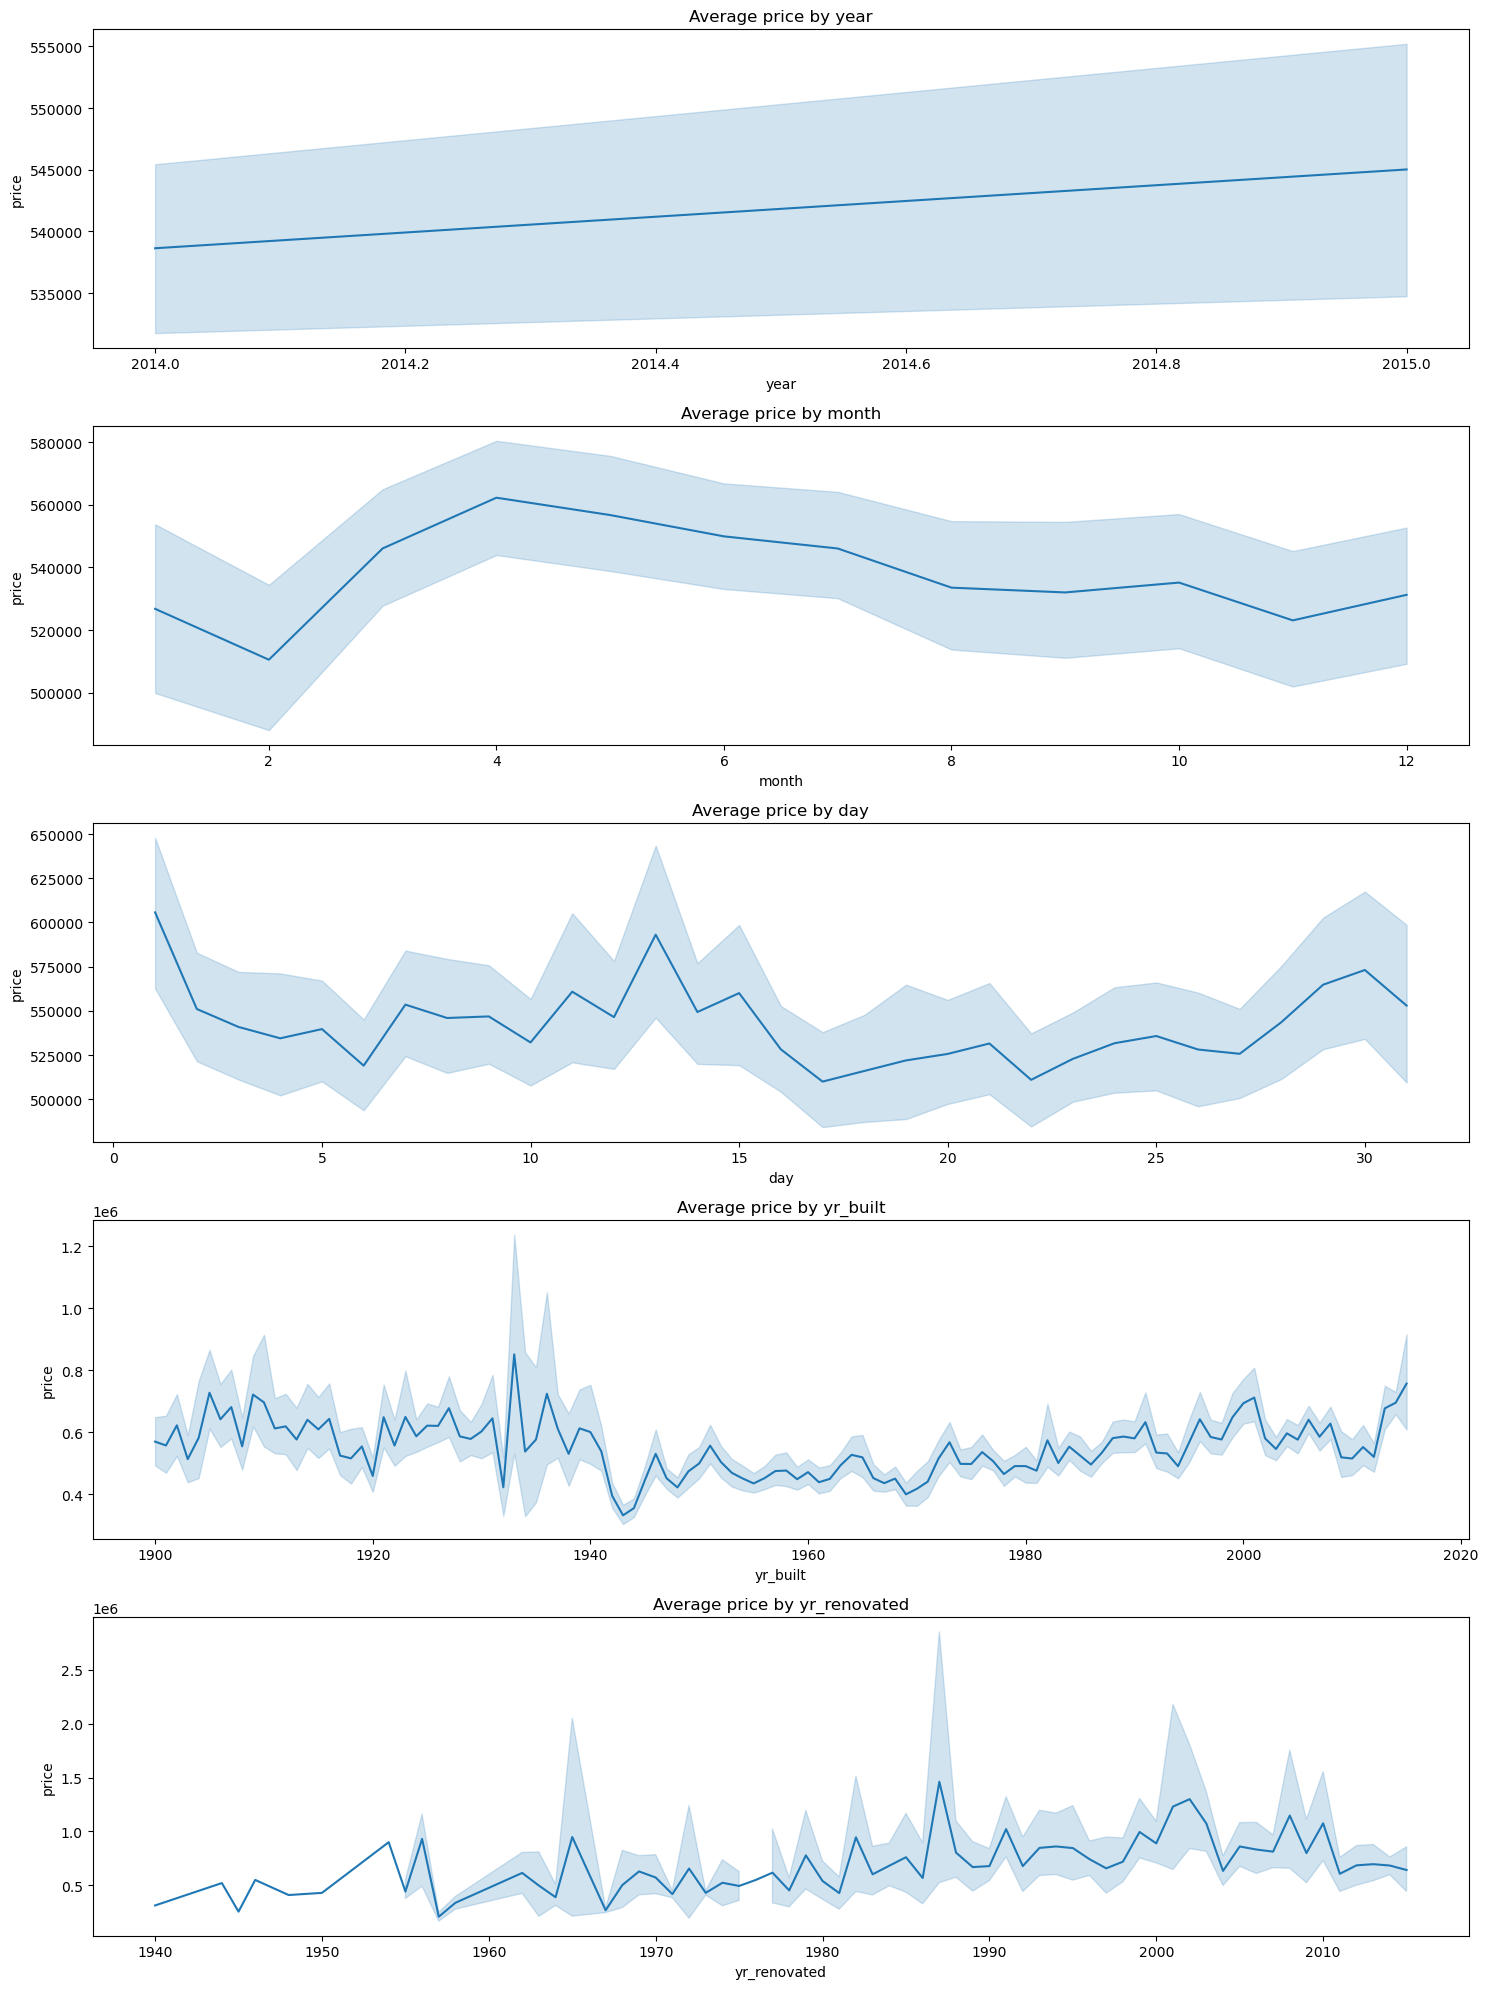

In [64]:
# 년,월,일에 따른 price 가격 흐름 보기
# 지은 년도와 재건축 년도에 따른 가격흐름 보기

# 년도가 지날수록 늘어지만, 신뢰구간이 굉장히 넓음
# 봄에 높아지고 겨울에 낮아지는 구간을 볼 수 있음
# 월초, 월중, 월말에 높아지는 것을 볼 수 있음
# 지은 년도에는 음... 과거가 의외로 높다. 80년대부터 다시 높아지는 추세고
# 재건축 년도는 모르겠다.

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))
axes = axes.flatten()

for i, feature in enumerate(time_vars):
    if feature == "yr_renovated":
        tt = train.copy()
        tt['yr_renovated'] = tt['yr_renovated'].replace(0, np.nan)
        sns.lineplot(x=feature, y='price', data=tt, ax=axes[i])
        axes[i].set_title(f'Average price by {feature}')
    else:
        sns.lineplot(x=feature, y='price', data=train, ax=axes[i])
        axes[i].set_title(f'Average price by {feature}')

plt.tight_layout()
plt.show()

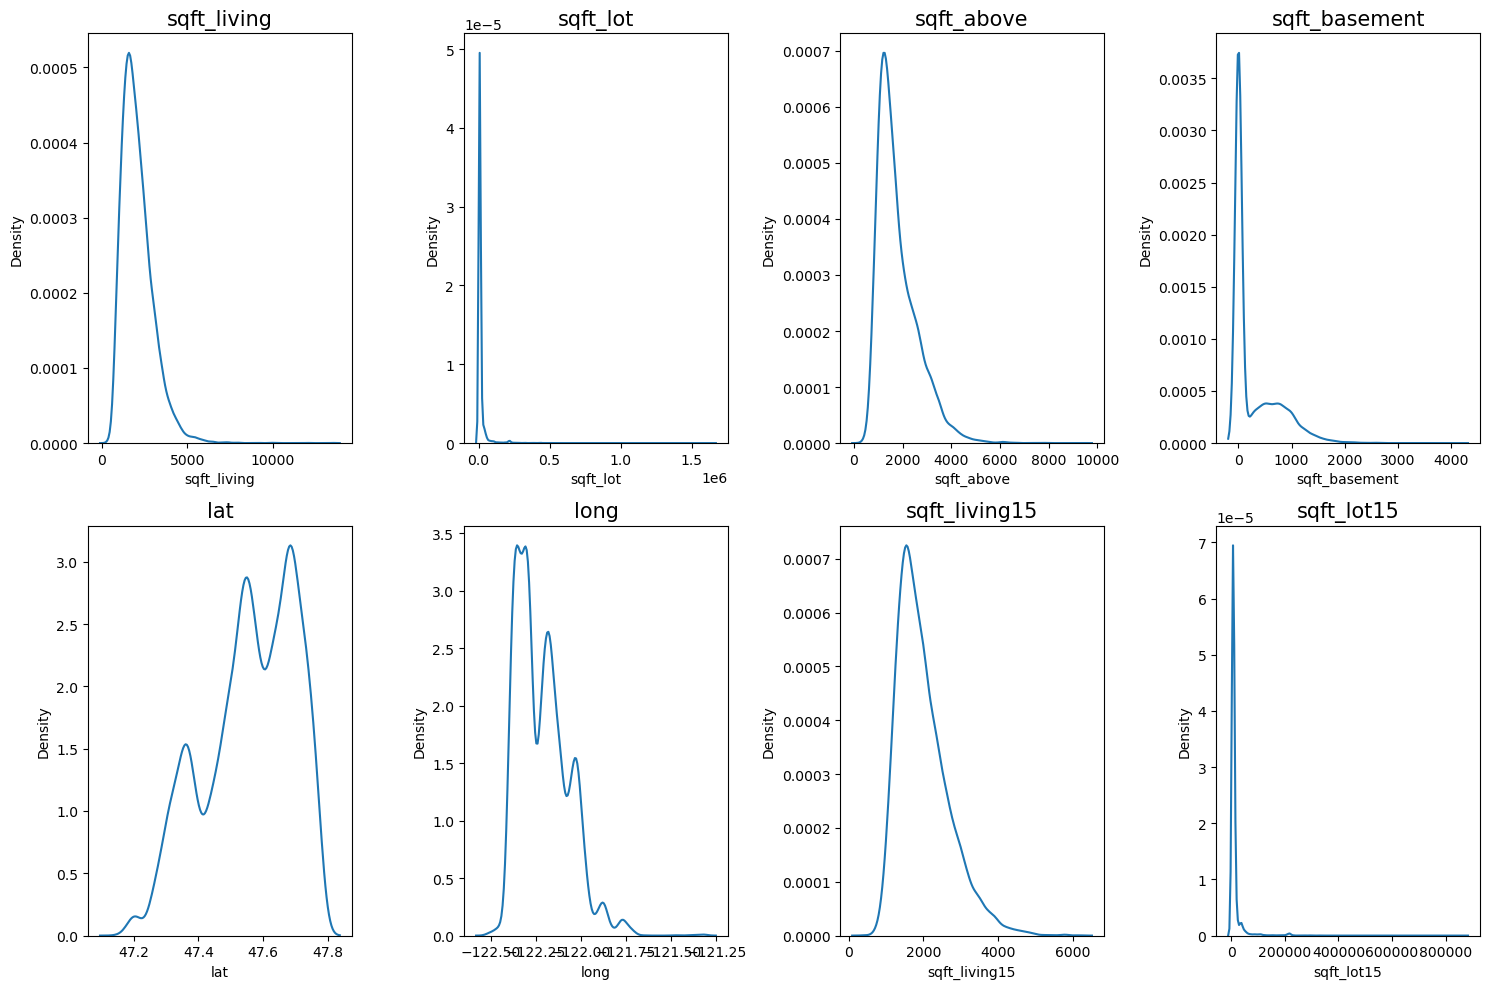

In [135]:
fig, ax = plt.subplots(2, 4, figsize=(15, 10))   

skewness_dict = {}  # 왜도를 저장할 딕셔너리 생성

count = 0
columns = train[continuous_vars].columns
for row in range(2):
    for col in range(4):
            
        current_column = columns[count]
        
        # 현재 컬럼의 왜도를 계산해 딕셔너리에 저장
        skewness_dict[current_column] = train[current_column].skew()
        
        sns.kdeplot(data=train[current_column], ax=ax[row][col])
        ax[row][col].set_title(current_column, fontsize=15)
        count += 1
        if count >= len(train[continuous_vars].columns)+1:
            break

plt.tight_layout()
plt.show()

In [66]:
skew_df = pd.DataFrame({'Feature': skewness_dict.keys(), 'Skewness': skewness_dict.values()})
print(skew_df.sort_values(by='Skewness', ascending=False))

         Feature   Skewness
1       sqft_lot  13.350500
7     sqft_lot15  10.028412
3  sqft_basement   1.556555
0    sqft_living   1.492472
2     sqft_above   1.429070
6  sqft_living15   1.125932
5           long   0.917991
4            lat  -0.488040


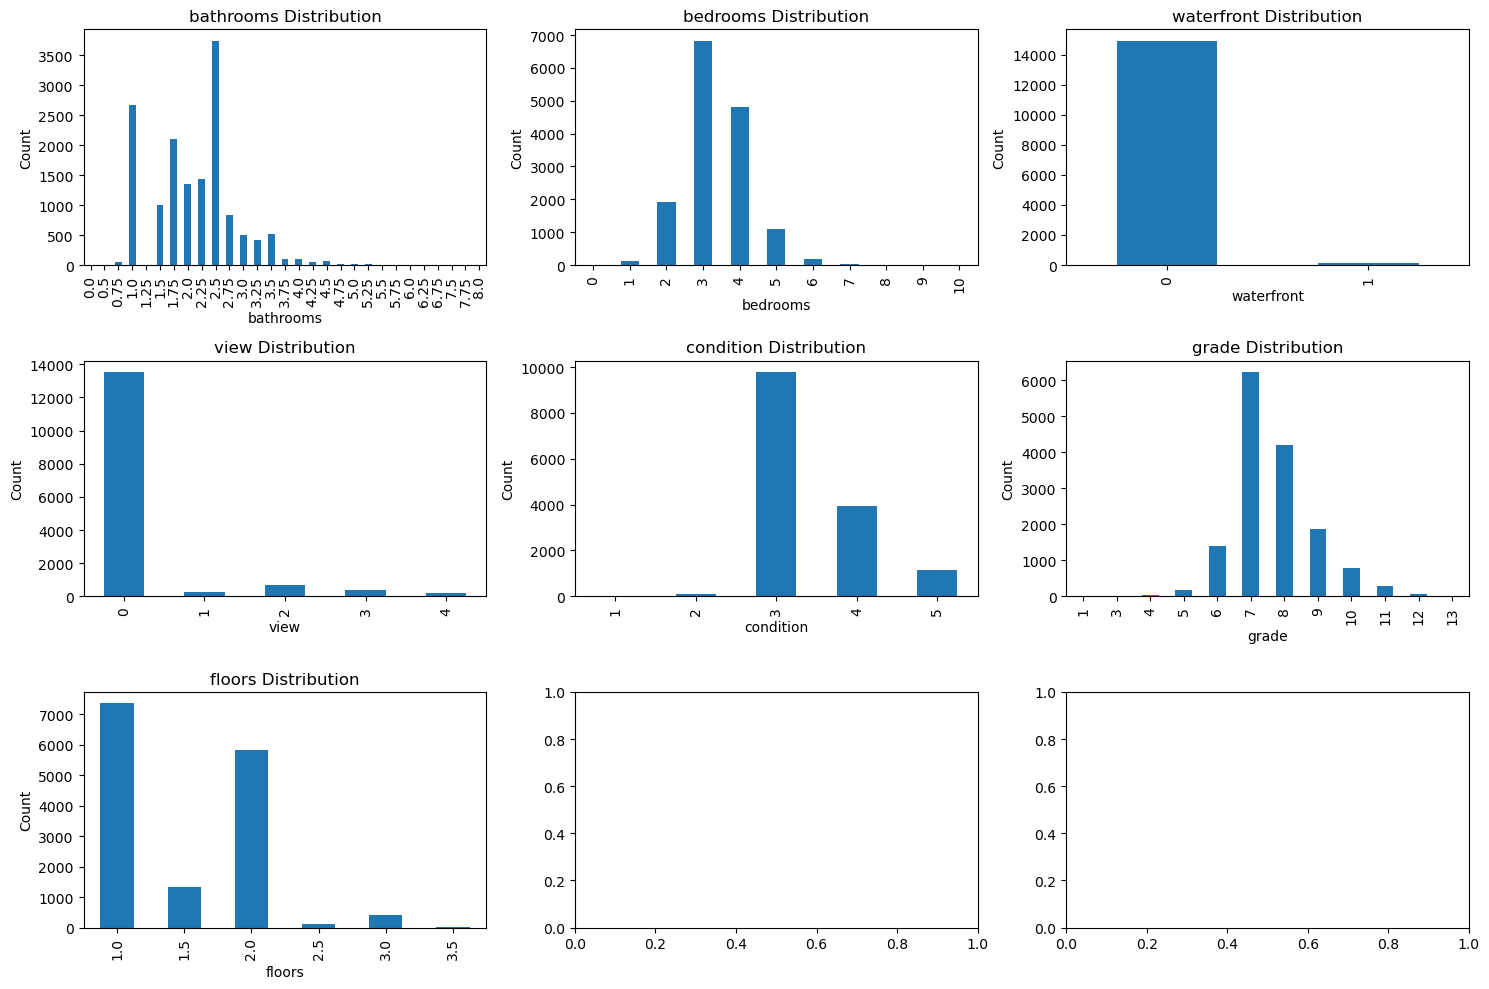

In [67]:
# 각 변수에 대해 Value Counts 플롯
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()  

for i, var in enumerate(discrete_vars):
    if var == 'zipcode':
        continue
    
    else:
        train[var].value_counts().sort_index().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{var} Distribution')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

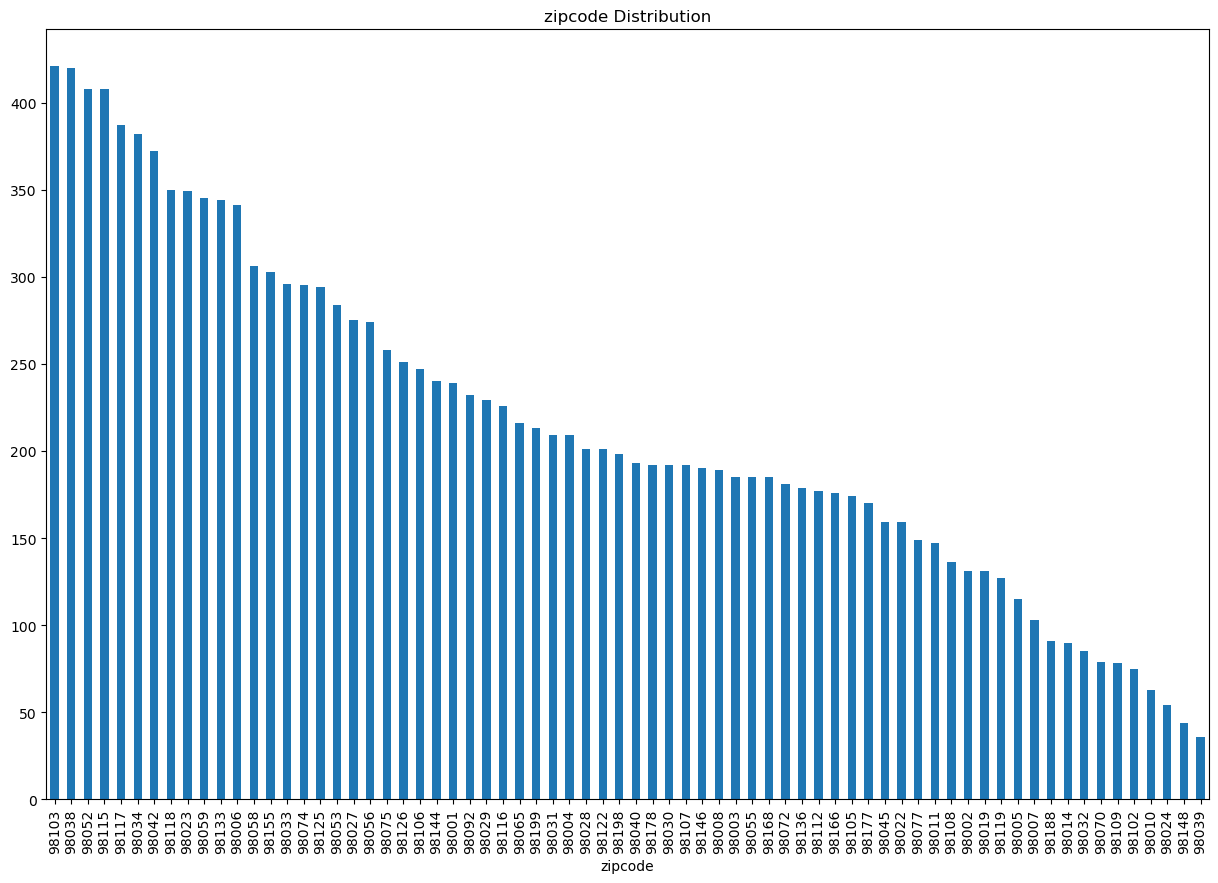

In [68]:
plt.figure(figsize=(15,10))
train['zipcode'].value_counts().plot(kind='bar')
plt.title('zipcode Distribution')
plt.show()

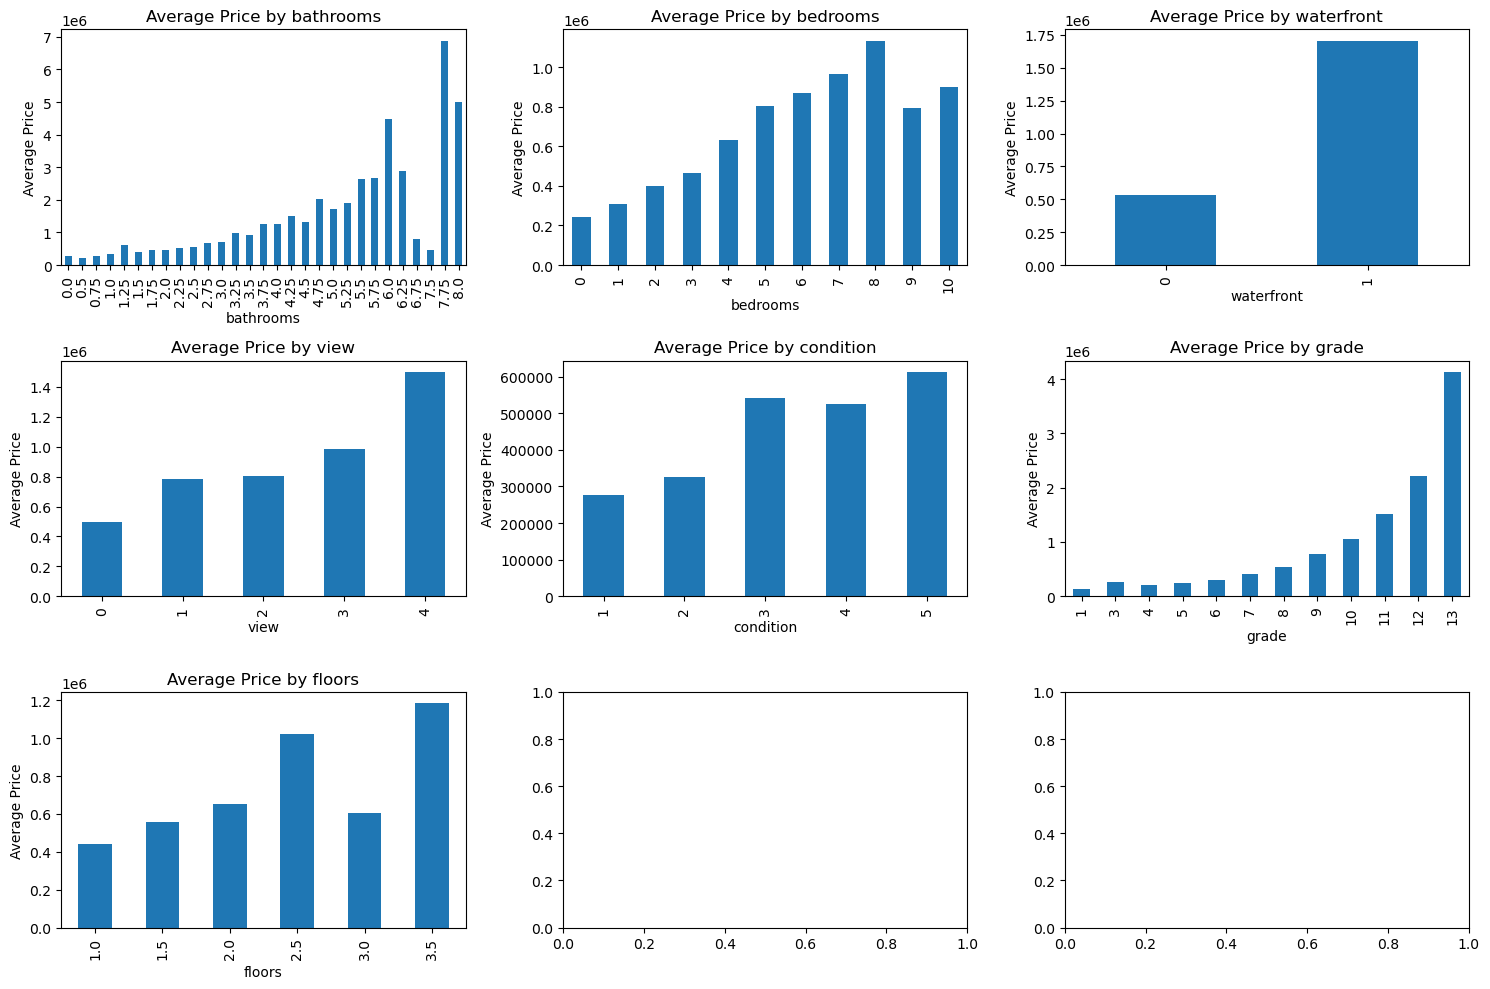

In [69]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(discrete_vars):
    if var == 'zipcode':
        continue
    else:
        var_price = train.groupby(var)['price'].mean().sort_index()
        var_price.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average Price by {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Average Price')

plt.tight_layout()
plt.show()

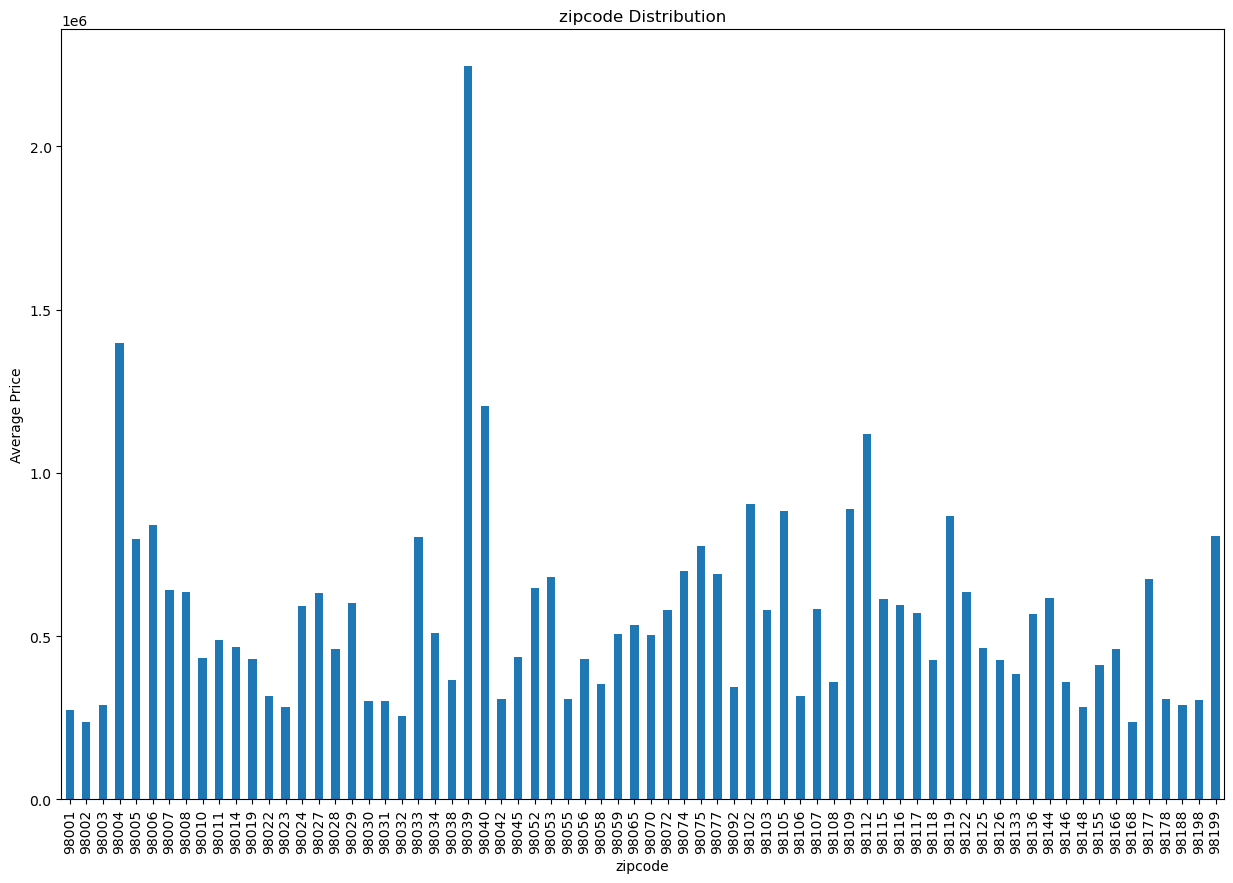

In [70]:

plt.figure(figsize=(15,10))
var_price = train.groupby(var)['price'].mean().sort_index()
var_price.plot(kind='bar')
plt.xlabel('zipcode')
plt.ylabel('Average Price')
plt.title('zipcode Distribution')
plt.show()

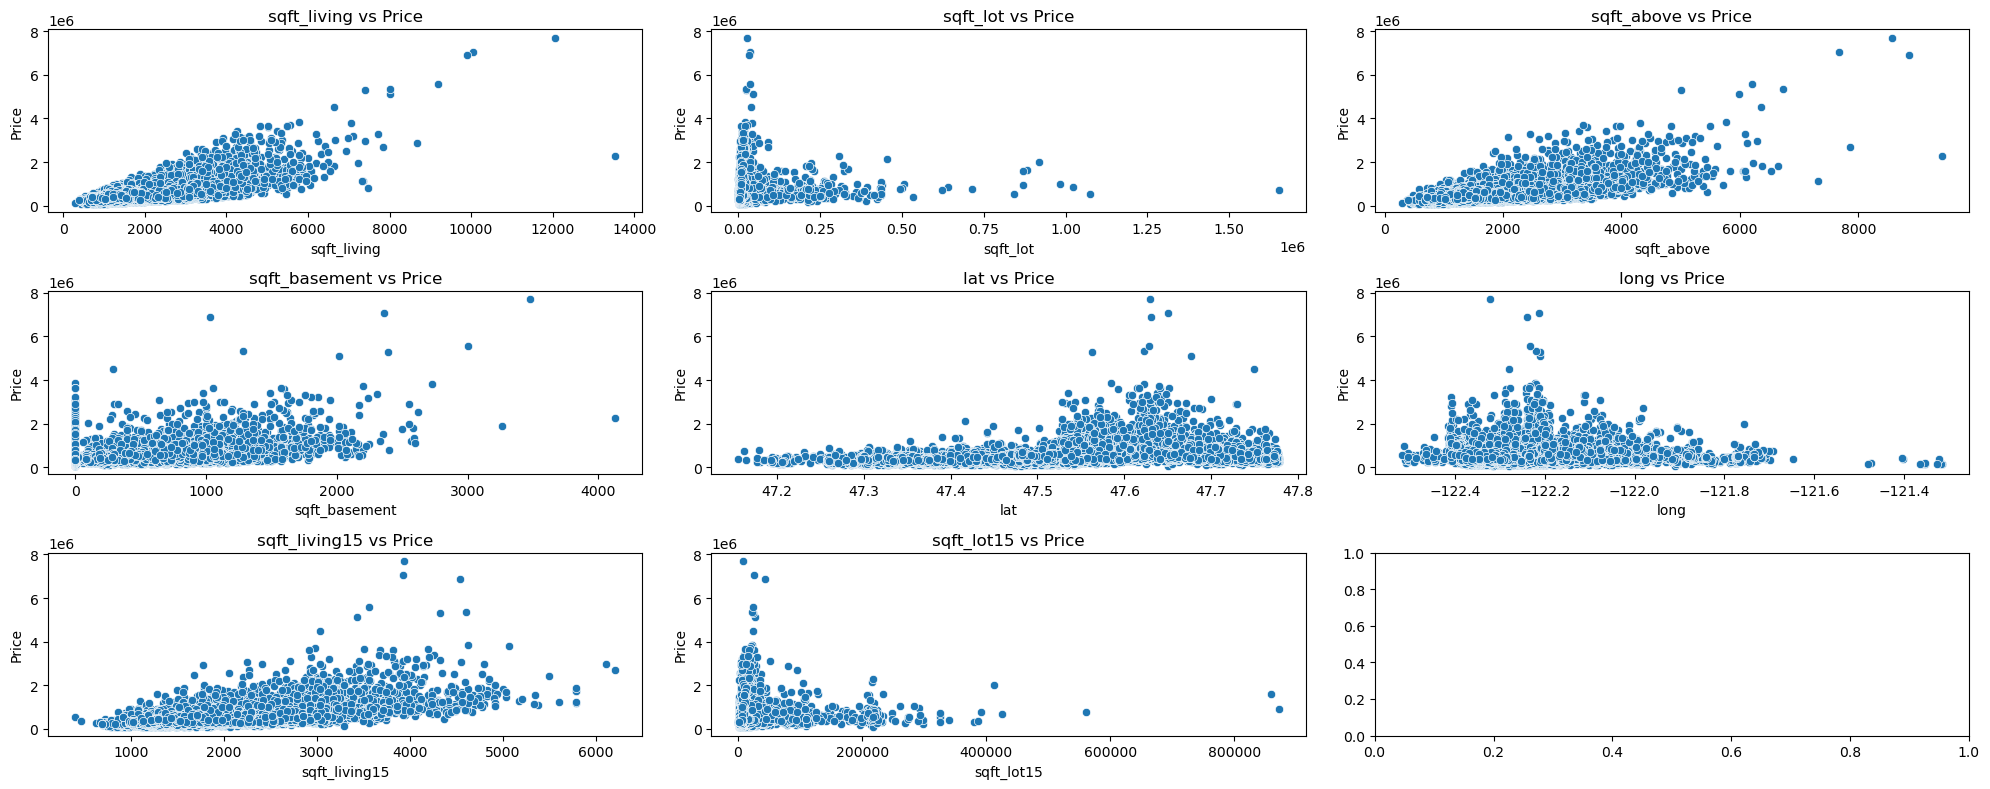

In [71]:
# 각 연속형 변수에 대해 Scatter Plot
# sqft_lot과 sqft_lot15는 그래프를 봐도, 상관계수를 봐도 target에 의미가 없어보임.

fig, axes = plt.subplots(3, 3, figsize=(20, 8))
axes = axes.flatten()  


for i, var in enumerate(continuous_vars):
    sns.scatterplot(x=var, y='price', data=train, ax=axes[i])
    axes[i].set_title(f'{var} vs Price')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

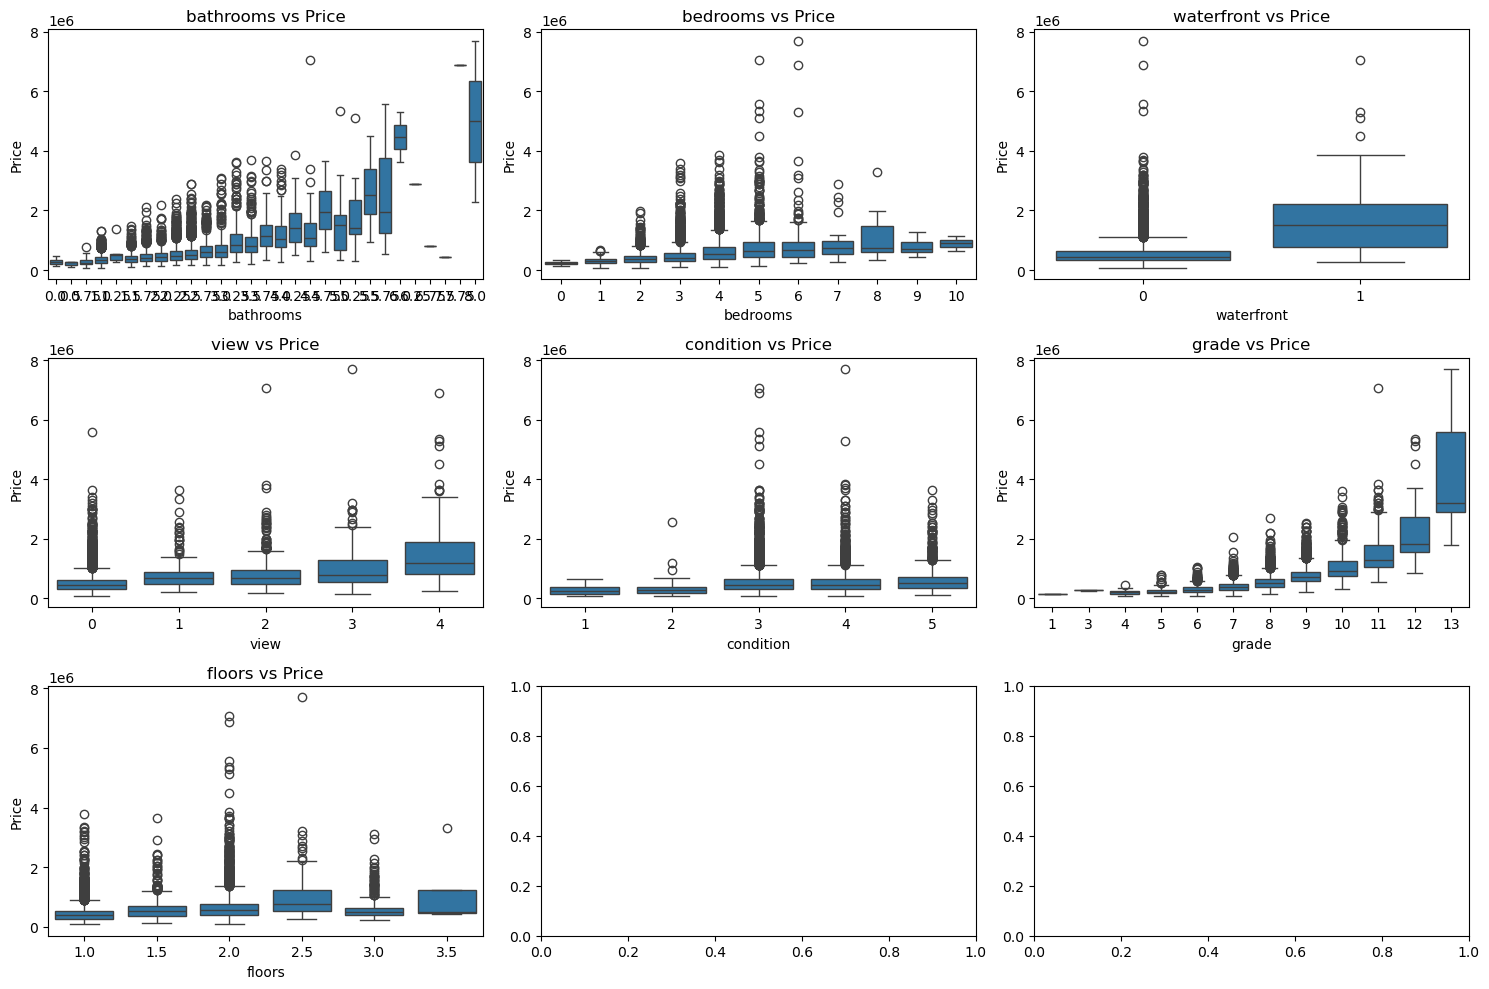

In [72]:
# 각 이산형 변수에 대해 Boxplot
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()  

for i, var in enumerate(discrete_vars):
    if var == 'zipcode':
        continue
    else:
        sns.boxplot(x=var, y='price', data=train, ax=axes[i])
    axes[i].set_title(f'{var} vs Price')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

<Axes: xlabel='lat', ylabel='long'>

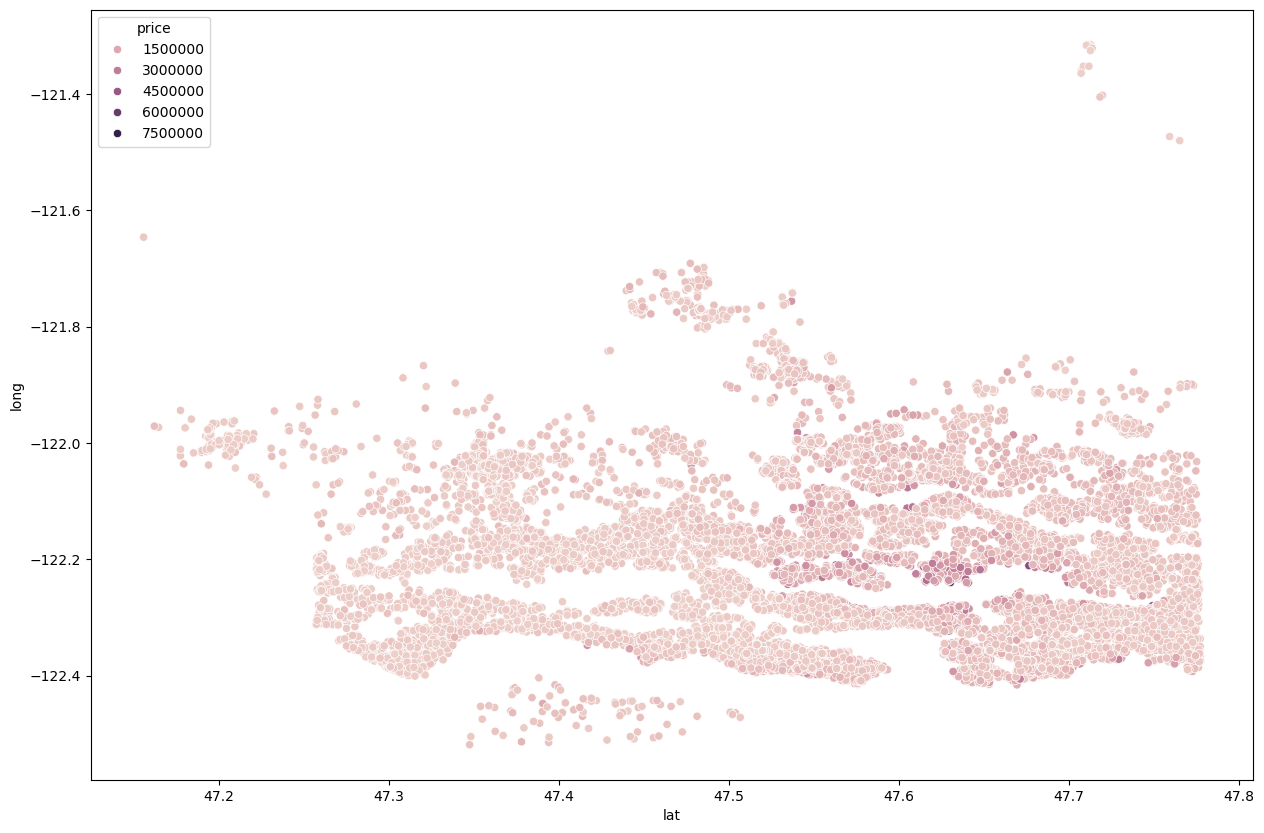

In [73]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=train, x='lat', y='long', hue='price')

### 지도 (위도 경도 -> price 분포)

In [136]:
import folium
import pandas as pd
from branca.colormap import linear

df = train.copy()

map_center = [df['lat'].mean(), df['long'].mean()]
m = folium.Map(location=map_center, zoom_start=11)

colormap = linear.PiYG_05.scale(df['price'].min(), df['price'].max())
    
for idx, row in df.iterrows(): # 데이터 전부다 하니 시간 약간 걸림.
    lat, lon, price = row['lat'], row['long'], row['price']
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,# 원의 크기
        popup=f"Price: ${price:,.0f}", 
        color=colormap(price), 
        fill=True,
        fill_color=colormap(price),
        fill_opacity=0.7
    ).add_to(m)
# 지도 출력
# m

In [75]:
# 색상 보는거라 신경 X
#linear

In [15]:
# 이지연님 전처리 코드 추가
def zip2location(data):
    nomi = pgeocode.Nominatim('us')
    cities, counties = [], []
    for z in data['zipcode']:
        location = nomi.query_postal_code(z)
        if location is not None and not location.isnull().all():
            cities.append(location.place_name)
            counties.append(location.county_name)
        else:
            cities.append(None)
            counties.append(None)

    data['city'] = cities
    data['county'] = counties

    return data
    
zip2location(train)
zip2location(test)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,city,county
0,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,98125,47.7210,-122.319,1690,7639,2014,12,9,Seattle,King
1,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,98136,47.5208,-122.393,1360,5000,2014,12,9,Seattle,King
2,4,4.50,5420,101930,1.0,0,0,3,11,3890,...,98053,47.6561,-122.005,4760,101930,2014,5,12,Redmond,King
3,3,1.00,1780,7470,1.0,0,0,3,7,1050,...,98146,47.5123,-122.337,1780,8113,2015,4,15,Seattle,King
4,3,2.50,1890,6560,2.0,0,0,3,7,1890,...,98038,47.3684,-122.031,2390,7570,2015,3,12,Maple Valley,King
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,3,1.75,1500,11968,1.0,0,0,3,6,1500,...,98010,47.3095,-122.002,1320,11303,2014,6,26,Black Diamond,King
6464,3,2.00,1490,1126,3.0,0,0,3,8,1490,...,98144,47.5699,-122.288,1400,1230,2015,1,26,Seattle,King
6465,3,2.50,1310,1294,2.0,0,0,3,8,1180,...,98116,47.5773,-122.409,1330,1265,2015,2,19,Seattle,King
6466,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,98144,47.5944,-122.299,1020,2007,2014,6,23,Seattle,King


In [16]:
train.city.value_counts()

city
Seattle          6269
Renton           1110
Bellevue          957
Kent              858
Redmond           692
Kirkland          678
Auburn            602
Sammamish         553
Federal Way       534
Issaquah          504
Maple Valley      420
Woodinville       330
Snoqualmie        216
Kenmore           201
Mercer Island     193
Enumclaw          159
North Bend        159
Bothell           147
Duvall            131
Carnation          90
Vashon             79
Black Diamond      63
Fall City          54
Medina             36
Name: count, dtype: int64

In [17]:
train.county.value_counts()

county
King         14886
Snohomish      149
Name: count, dtype: int64

# EDA 후 전처리

In [66]:
df_train = train.drop(columns='price').copy()
df_test = test.copy()

target = train.price

print(df_train.shape)
print(df_test.shape)

(15035, 23)
(6468, 23)


In [60]:
#df_train = df_train.drop(columns=['sqft_lot','sqft_lot15'])
#df_test = df_test.drop(columns=['sqft_lot','sqft_lot15'])

#print(df_train.shape)
#print(df_test.shape)

(15035, 21)
(6468, 21)


In [67]:
skew_columns = ['sqft_basement','sqft_lot','sqft_lot15']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [68]:
# 그냥 원핫인코딩 할 경우, train에 있는 특정 변수의 고유값이 test에는 없어서 차원 개수가 달라지는 문제가 생김

discrete_vars

df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

# 원-핫 인코딩할 컬럼 리스트
ohe_vars = [var for var in discrete_vars+['city','county'] if var not in ['floors', 'zipcode']]

train_len = len(df_train_orig)
combined = pd.concat([df_train_orig, df_test_orig], axis=0)

combined_ohe = pd.get_dummies(combined, columns=ohe_vars, drop_first=True)


df_train = combined_ohe.iloc[:train_len]
df_test = combined_ohe.iloc[train_len:]

print(df_train.shape)
print(df_test.shape)

(15035, 100)
(6468, 100)


In [105]:
# 표준화 폐기 성능이 5배이상으로 나빠짐
# 생각해보니, 다른 이유때문에 나빠진듯하기도 하고? 트리기반 모델이라 사실 표준화나 정규화가 의미가 크게 없을텐데?
#ss = StandardScaler()  
#ss_scaler = ss.fit_transform(df_train[continuous_vars+discrete_vars+time_vars])
#df_train[continuous_vars+discrete_vars+time_vars] = ss_scaler
#ss_scaler = ss.transform(df_test[continuous_vars+discrete_vars+time_vars])
#df_test[continuous_vars+discrete_vars+time_vars] = ss_scaler

In [106]:
# 전처리는 나중에 시간 되면 더 ㄱㄱ 

# 모델

In [70]:
X_train = df_train.copy()
y_train = target

print(X_train.shape)
print(y_train.shape)

model = xgb.XGBRegressor(random_state=42)

# XGBoost에 맞는 하이퍼파라미터 그리드 정의
# 그리드 정의인데, 아래처럼 할거면 왜 하냐하면
# 앞서 여러번 그리드 돌리다가... n_estimators 높을수록 좋고, 나머지는 아래 수치에서만 계속 best로 뜨기도 하고
# 자기 직전 빠르게 돌려보자 하고 돌려봤는데, 마침 기준치에 도달해서...
param_grid = {
    'n_estimators': [10000],
    'learning_rate': [0.01],
    'max_depth': [5],
    'colsample_bytree': [0.6],
    'reg_lambda': [1]
}


grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최고 점수 출력 (음수로 나옴)
print("최고 교차 검증 점수 (neg_rmse):", grid_search.best_score_)

# 실제 RMSE 값
print("최고 교차 검증 점수 (RMSE):", np.abs(grid_search.best_score_))

(15035, 100)
(15035,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
최적의 하이퍼파라미터: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10000, 'reg_lambda': 1}
최고 교차 검증 점수 (neg_rmse): -123008.42753464438
최고 교차 검증 점수 (RMSE): 123008.42753464438


In [71]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(df_test)

In [72]:
sub = pd.DataFrame(data={'id':sub_id,'price':predictions})
sub.to_csv('submission17.csv', index=False)

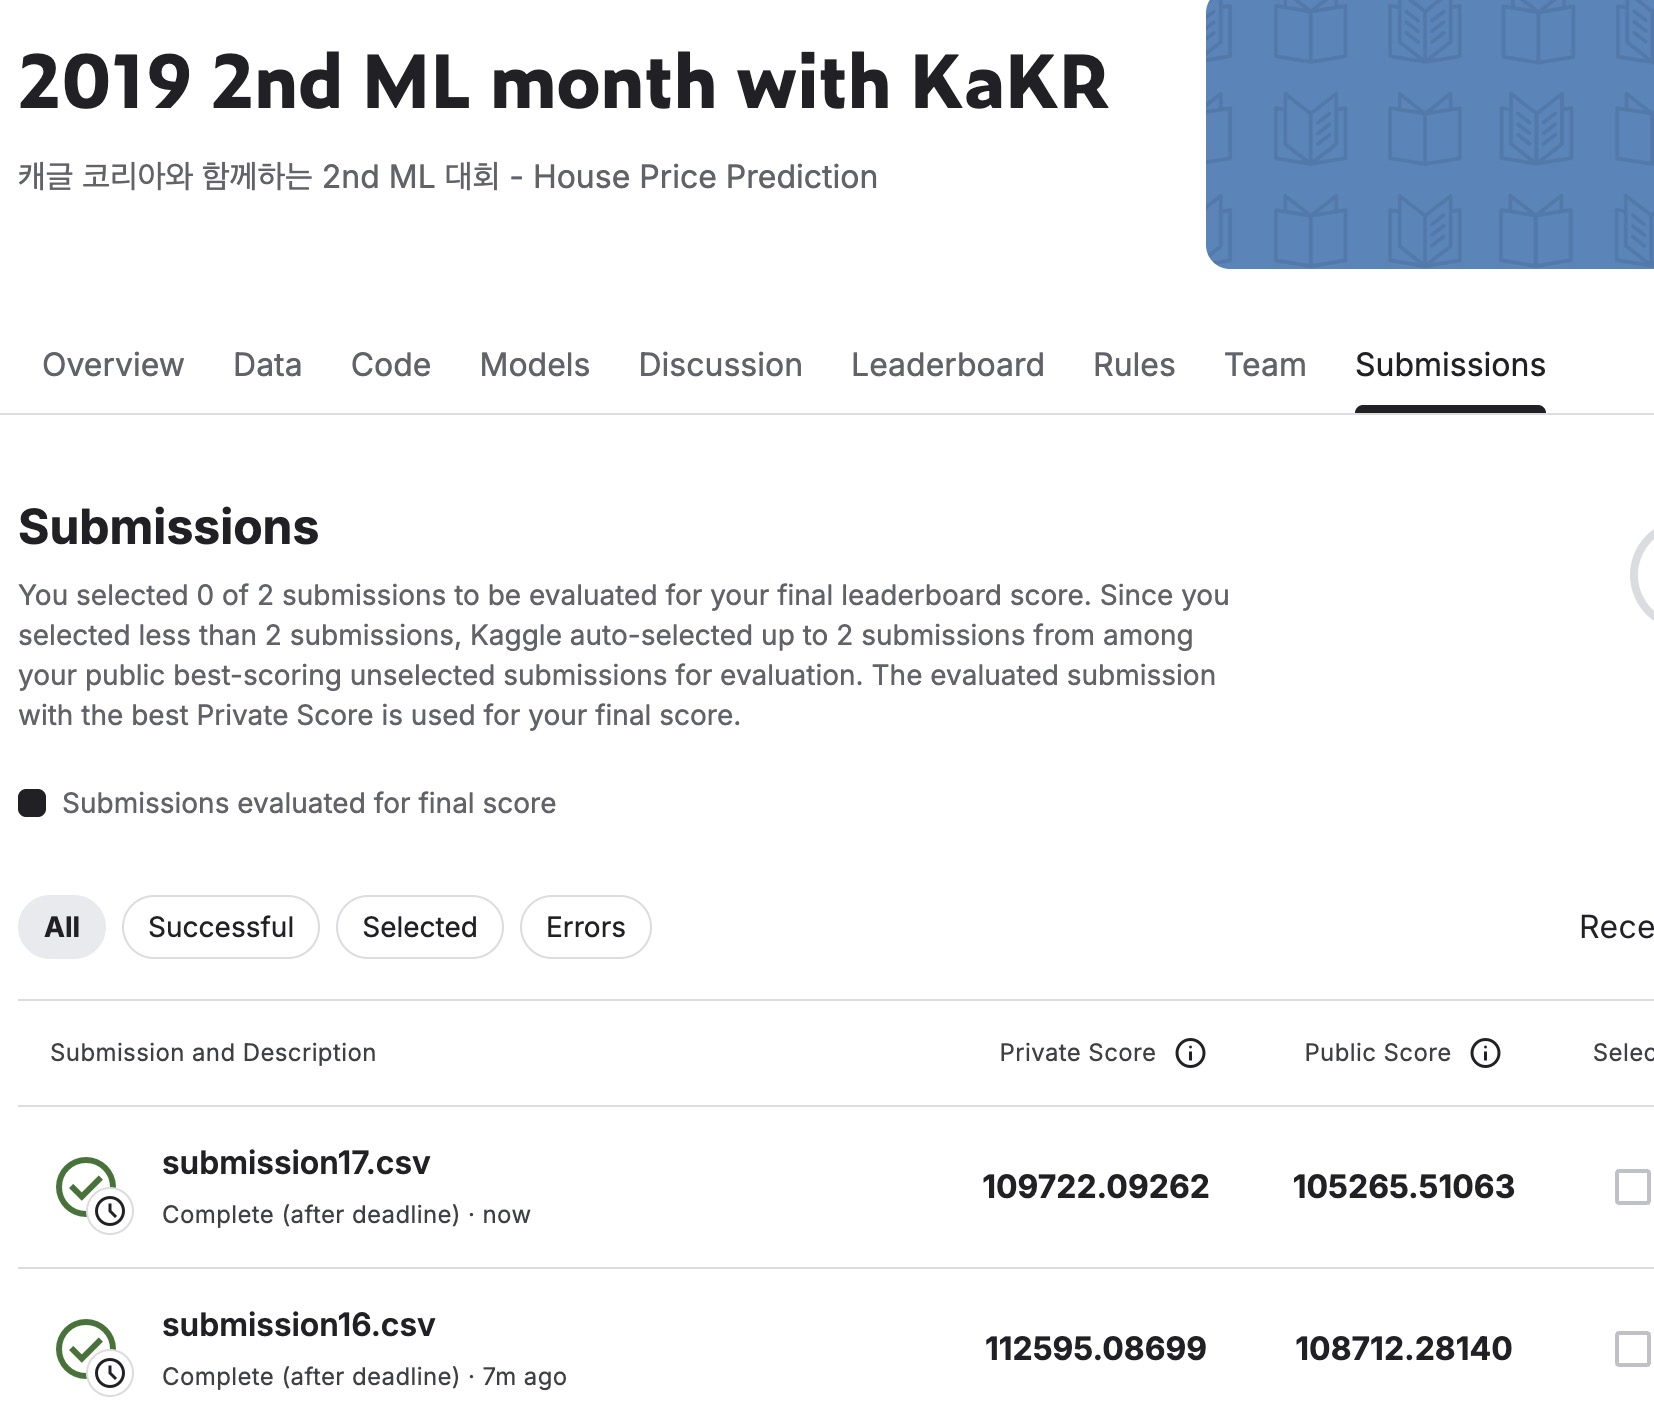